## Excel "What if?" analysis with Python - Part 2: Goal Seek


In the [first part of this series](http://hselab.org/excel-to-python-1-models-datatables.html), I introduced the general idea of using Python for typical spreadsheet modeling activities. We built both object-oriented (OO) and non-OO versions of a basic business model (the Bookstore Model - it's repeated below for convenience) and learned a few things about doing OOP in Python. Then we designed and created a `data_table` function to do sensitivity analysis much like Excel's Data Table tool (though our Python version can handle an arbitrary number of both input and output variables).

Now we'll build on that work in part 2 by designing and creating a `goal_seek` function that is very similar to Excel's Goal Seek tool. As we did in part 1, we'll also be exploring some of Python's more advanced features. 

In the remainder of this document, we'll learn a bit about root finding as well as things like SciPy, partial function freezing, and function wrapping with lambda functions. When we are done, we'll have a `goal_seek` function to complement our `data_table` function. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection._search import ParameterGrid
import seaborn as sns
import copy

In [2]:
%matplotlib inline

### Bookstore model

For convenience, I'll describe the base model we are using throughout this series of Jupyter notebook based posts. This example is based on [one in the spreadsheet modeling textbook(s) I've used in my classes since 2001](https://host.kelley.iu.edu/albrightbooks/). I started out using Practical Management Science by Winston and Albright and switched to their Business Analytics: Data Analysis and Decision Making (Albright and Winston) around 2013ish. In both books, they introduce the "Walton Bookstore" problem in the chapter on Monte-Carlo simulation. Here's the basic problem (with a few modifications):

* we have to place an order for a perishable product (e.g. a calendar)
* there's a known unit cost for each one ordered
* we have a known selling price
* demand is uncertain but we can model it with some simple probability distribution
* for each unsold item, we can get a partial refund of our unit cost
* we need to select the order quantity for our one order for the year; orders can only be in multiples of 25


### Goal Seek

In addition to the type of sensitivity analysis enabled by the `data_table` function we created in the [first post in this series](http://hselab.org/excel-to-python-1-models-datatables.html), another typical Excel analytical task is to use Goal Seek to find, say, the break even level of demand. At its core, Goal Seek is just a root finder. So, in the Python world, it feels like the optimization routines in SciPy might be useful. Let's start with the non-OO version of our Bookstore Model

## Attempt at non-OO version of Goal Seek

This got tricky but led down all kinds of interesting side paths having to do with partial function freezing, lambda functions, currying, function signatures and more. Let's initialize our base input values.

In [3]:
# Set all of our base input values
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50

demand = 193

order_quantity = 250

Back in the first post in this series, we then created a function that took all of our base inputs as input arguments and returned a value for profit.

In [4]:
def bookstore_profit(unit_cost, selling_price, unit_refund, order_quantity, demand):
    '''
    Compute profit in bookstore model
    '''
    order_cost = unit_cost * order_quantity
    sales_revenue = np.minimum(order_quantity, demand) * selling_price
    refund_revenue = np.maximum(0, order_quantity - demand) * unit_refund 
    profit = sales_revenue + refund_revenue - order_cost
    return profit

Let's try it out.

In [5]:
bookstore_profit(unit_cost, selling_price, unit_refund, order_quantity, demand)

197.5

### A bit about root finding using a simpler example

Now let's try to find the break even value for demand; i.e. the level of demand that leads to a profit of zero. As mentioned above, this is a root finding problem - finding where the profit function crosses the x-axis. The [SciPy package has various root finding and optimization functions](https://docs.scipy.org/doc/scipy/reference/optimize.html). 

Reading that page, we eventually get down to the root finding section and find the main function, [root_scalar](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html#scipy.optimize.root_scalar). Before trying to use this this function for our bookstore model, let's consider a simpler example - a quadratic function.

In [6]:
def simple_function(x):
    '''x^2 - 3x - 5'''
    return x ** 2 - 3 * x - 5

In [7]:
simple_function(2)

-7

In [8]:
simple_function(10)

65

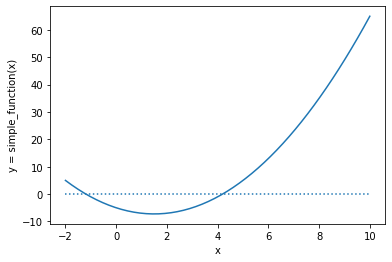

In [9]:
left_bracket = -2
right_bracket = 10
x = np.linspace(left_bracket, right_bracket)
y = simple_function(x)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y = simple_function(x)')
plt.hlines(0, left_bracket, right_bracket, linestyles='dotted')
plt.show()

To use `scipy.optimize.root_scalar` to find the value of `x` where `simple_function(x)` is equal to zero, we call the `root_scalar` and pass in the following input arguments:

* the function - in our case, this is `simple_function`
* the root finding method - we'll use `bisect` as it's simple, converges, and doesn't require any derivative information. See https://www.youtube.com/watch?v=MlP_W-obuNg for an explanation of how bisection search works and how it can be easily implemented in Python. The basic idea is:
    - divide search region in half
    - see if root lies in left half or right half by checking if sign changes from beginning of left half to midpoint,
    - discard the half not containing the root
    - repeat the above until hit root exactly (or close enough) or reach iteration limit.
* a bracket (required for some methods) - if we can define a range `[a, b]` within which we know the root occurs such that $f(a)$ and $f(b)$ have different signs, we can supply it. For example, in our `simple_function` example, we know it must cross zero somewhere between [-2, 0] and then again betwen [0, 10]. As you can imagine such a bracket will help immensely when there are multiple roots and lessen the effect of the initial guess. However, finding a range that brackets the root in a way that the sign changes at the endpoints of the bracket may be quite a difficult task.
* an initial guess (optional) - many root finding algorithms will perform better if we are able to give a reasonable guess as to where the root might be.

If you've ever used Excel's Goal Seek tool, you may have stumbled on behaviors that are related to the list and plot above.

* Goal Seek doesn't allow you to tell it a whole lot in terms of how it attempts to find roots. We don't get to specify the method and we don't get to bracket the root. But, ...
* Goal Seek does use the current cell value of the *Changing Cell* as an initial guess
* If our spreadsheet model does have multiple roots, the root returned by Goal Seek will depend on our initial guess.

For example, here are the results of using Goal Seek to drive `simple_function(x)` to 0 with different initial guesses. Note that the function is minimized at $x=1.5$.

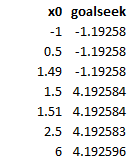

Let's try a few different root finding functions available in SciPy.

* `fsolve` - this appears to be a legacy function but doesn't require us to bracket the root such that $f(a)$ and $f(b)$ have different signs. Of course, the root it returns will likely be impacted by the initial guess (just as Goal Seek is).  
* `root_scalar` - this is a newer, more general, function for which we can specify specifics such as the root finding algorithm. Most of the methods require a root bracket.

In [10]:
from scipy.optimize import root_scalar
from scipy.optimize import fsolve

In [11]:
# fsolve - very similar to Goal Seek
init_values = [-1, 0.5, 1.49, 1.5, 1.51, 2.5, 6]

[(x, fsolve(simple_function, x)) for x in init_values]
    

[(-1, array([-1.1925824])),
 (0.5, array([-1.1925824])),
 (1.49, array([-1.1925824])),
 (1.5, array([4.1925824])),
 (1.51, array([4.1925824])),
 (2.5, array([4.1925824])),
 (6, array([4.1925824]))]

Now let's try `root_scalar`.

In [12]:
# Left root
init_values_1 = [-1, -0.5, 0.0]
[(x, root_scalar(simple_function, method='bisect', bracket=[-2, 0], x1=x).root) for x in init_values_1]

[(-1, -1.1925824035661208),
 (-0.5, -1.1925824035661208),
 (0.0, -1.1925824035661208)]

In [13]:
# Right root
init_values_2 = [0.0, 0.5, 1, 4, 10]
[(x, root_scalar(simple_function, method='bisect', bracket=[0, 10], x1=x).root) for x in init_values_2]
    

[(0.0, 4.192582403567258),
 (0.5, 4.192582403567258),
 (1, 4.192582403567258),
 (4, 4.192582403567258),
 (10, 4.192582403567258)]

Great. In this contrived case in which we can easily write a function to compute the derivative of `simple_function`, we could use Newton's method instead of bisection search (or others) that require bracketing. Sometimes, just bracketing the root might be really hard. Of course, then the initial guess will matter a lot and we should be able to duplicate Goal Seek's behavior. In real spreadsheet life, we probably don't have a closed form solution for the derivative, though we could likely approximate it pretty well as long as it wasn't super jumpy. 

Check out http://www.math.pitt.edu/~troy/math2070/lab_04.html if you want to play around in Python with different root finding algorithms.

Anyway, let's give Newton's a go.

In [14]:
def simple_function_prime(x):
    '''Derivative of x^2 - 3x - 5'''
    return 2 * x - 3

In [15]:
init_values = [-1, 0.5, 1.49, 1.5, 1.51, 2.5, 6]

[(x, root_scalar(simple_function, method='newton', fprime=simple_function_prime, x0=x).root) for x in init_values]

C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\scipy\optimize\zeros.py:295: RuntimeWarning: Derivative was zero.
  warnings.warn(msg, RuntimeWarning)


[(-1, -1.192582403567252),
 (0.5, -1.1925824035672519),
 (1.49, -1.192582403567252),
 (1.5, 1.5),
 (1.51, 4.192582403567251),
 (2.5, 4.192582403567252),
 (6, 4.192582403567252)]

Notice that with Newton's Method, we got the same behavior as Goal Seek, except for when we used an initial guess of 1.5. Of course, this is the point at which `simple_function` is minimized and the derivative is 0. We get a warning about that and instead of arbitrarily going in one direction or the other, `root_scalar` just bailed and gave us back our original guess. These root finding functions actually [return much more info than just the root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.RootResults.html#scipy.optimize.RootResults).

In [16]:
print(root_scalar(simple_function, method='newton', fprime=simple_function_prime, x0=1))

      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 7
           root: -1.192582403567252


In [17]:
print(root_scalar(simple_function, method='newton', fprime=simple_function_prime, x0=1.5))

      converged: False
           flag: 'convergence error'
 function_calls: 2
     iterations: 1
           root: 1.5


Try out different methods and you'll see that some take longer than others to converge. Bisection search is [known to be slow but safe](https://www.youtube.com/watch?v=MlP_W-obuNg&t=138s).

In [18]:
print(root_scalar(simple_function, method='bisect', bracket=[0, 10], x1=1))

      converged: True
           flag: 'converged'
 function_calls: 45
     iterations: 43
           root: 4.192582403567258


### Back to the Bookstore Model and partial functions
You may have already been wondering how exactly we might use SciPy's root finding functions with our `bookstore_profit` function since it doesn't just have one input argument, it's got five. How do we tell `root_scalar` which one of the inputs (e.g. demand) is the one we want to search over and that we want all the other arguments to remain fixed at specific values? This is a job for something known as a [partial function](https://www.learnpython.org/en/Partial_functions). The idea is to create a new function object that is based on an existing function, but with some of the function's inputs set to fixed values. To create partial functions, we need to use the `partial` function from the `functools` library. Unfortunately, while this initially seemed easy, we quickly ran into problems. 

So, for our purposes, I'm just going immediately jump to the OO version of the `BookstoreModel`. If you are interested in the details regarding the challenge described above, then see the [blog post version of this tutorial](http://hselab.org/excel-to-python-2-goalseek.html).

## Goal Seeking with the OO BookstoreModel
Back in the first post of the series, we created a `BookstoreModel` class which contained methods for computing profit and other output measures, updating input parameters, and some other useful tasks. Here's the class we ended up with:

In [19]:
class BookstoreModel():
    def __init__(self, unit_cost=0, selling_price=0, unit_refund=0, 
                 order_quantity=0, demand=0):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
        
    def update(self, param_dict):
        """
        Update parameter values
        """
        for key in param_dict:
            setattr(self, key, param_dict[key])
        
    def order_cost(self):
        """Compute total order cost"""
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        """Compute sales revenue"""
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        """Compute revenue from refunds for unsold items"""
        return np.maximum(0, self.order_quantity - self.demand) * self.unit_refund
    
    def total_revenue(self):
        """Compute revenue from refunds and sales"""
        return self.sales_revenue() + self.refund_revenue()
    
    def profit(self):
        '''
        Compute profit in bookstore model
        '''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit
       
    def __str__(self):
        """
        Print dictionary of object attributes
        """
        return str(vars(self))

In the first post we also created a `data_table` function that takes a `BookstoreModel` object as input along with input variable ranges and a list of desired outputs to implement the equivalent of general Excel Data Table function which allows an arbitrary number of both inputs and outputs. Recall that in Excel we can either do a 1-way Data Table with any number of outputs or a 2-way table with a single output.

Here's that function and quick recap of its use.

In [20]:
def data_table(model, scenario_inputs, outputs):
    '''Create n-inputs by m-outputs data table.

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for computing outputs from inputs
    scenario_inputs : dict of str to sequence
        Keys are input variable names and values are sequence of values for each scenario for this variable. Is consumed by
        scikit-learn ParameterGrid() function. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
    outputs : list of str
        List of output variable names

    Returns
    -------
    results_df : pandas DataFrame
        Contains values of all outputs for every combination of scenario inputs
    '''
    
    # Clone the model using deepcopy
    model_clone = copy.deepcopy(model)
    
    # Create parameter grid
    dt_param_grid = list(ParameterGrid(scenario_inputs))
    
    # Create the table as a list of dictionaries
    results = []

    # Loop over the scenarios
    for params in dt_param_grid:
        # Update the model clone with scenario specific values
        model_clone.update(params)
        # Create a result dictionary based on a copy of the scenario inputs
        result = copy.copy(params)
        # Loop over the list of requested outputs
        for output in outputs:
            # Compute the output.
            out_val = getattr(model_clone, output)()
            # Add the output to the result dictionary
            result[output] = out_val
        
        # Append the result dictionary to the results list
        results.append(result)

    # Convert the results list (of dictionaries) to a pandas DataFrame and return it
    results_df = pd.DataFrame(results)
    return results_df

Okay, let's try it out. 

In [21]:
# Create a dictionary of base input values

base_inputs = {'unit_cost': 7.5, 
               'selling_price': 10.0, 
               'unit_refund': 2.5, 
               'order_quantity': 200, 
               'demand': 193}

In [22]:
# Create a new model with default input values (0's)
model_6 = BookstoreModel()
print(model_6)
model_6.profit()

{'unit_cost': 0, 'selling_price': 0, 'unit_refund': 0, 'order_quantity': 0, 'demand': 0}


0

In [23]:
# Update model with base inputs
model_6.update(base_inputs)
print(model_6)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [24]:
# Specify input ranges for scenarios (dictionary)
dt_param_ranges = {'demand': np.arange(70, 321, 25),
                   'order_quantity': np.arange(70, 321, 50)}

# Specify desired outputs (list)
outputs = ['profit', 'order_cost']

# Use data_table function
m6_dt1_df = data_table(model_6, dt_param_ranges, outputs)
m6_dt1_df

,demand,order_quantity,profit,order_cost
0,70,70,175.0,525.0
1,70,120,-75.0,900.0
2,70,170,-325.0,1275.0
3,70,220,-575.0,1650.0
4,70,270,-825.0,2025.0
...,...,...,...,...
61,320,120,300.0,900.0
62,320,170,425.0,1275.0
63,320,220,550.0,1650.0
64,320,270,675.0,2025.0


Let's plot the results using Seaborn.

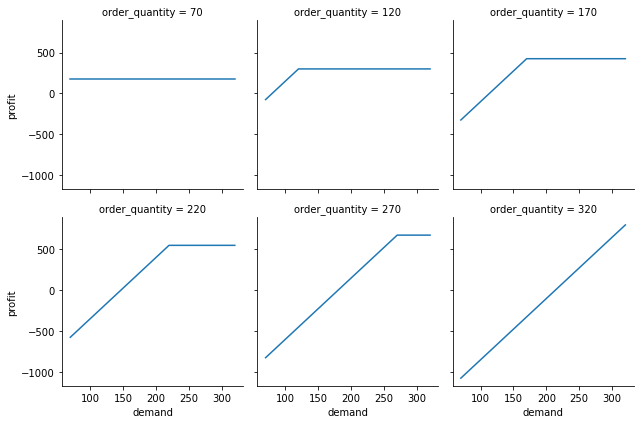

In [25]:
profit_dt_g = sns.FacetGrid(m6_dt1_df, col="order_quantity", sharey=True, col_wrap=3)
profit_dt_g = profit_dt_g.map(plt.plot, "demand", "profit")

### Adding a `goal_seek` function
As mentioned earlier in this notebook, there were a bunch of issues that popped up in trying to use SciPy's root finding functions with the non-OO model. For the OO model, it felt like I'd end up with similar problems in trying to write some sort of generic wrapper that would create functions to pass into things like `root_scalar`. Instead, I decided to simply bypass SciPy and write my own root finder that I could tailor to our goal seeking problem. When I say "write", I mean find a good implementation that someone has already done and tweak it. 

For example, https://github.com/patrickwalls/mathematical-python/ has nice implementations of various root finding methods. It was a pretty simple matter to adapt the [bisection function he wrote in this notebook](https://github.com/patrickwalls/mathematical-python/blob/master/roots-optimization/bisection.ipynb) to use in my `goal_seek` function. 

In [26]:
def goal_seek(model, obj_fn, target, by_changing, a, b, N=100, verbose=False):
    '''Approximate solution of f(x)=0 on interval [a,b] by bisection method.

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for doing the desired goal seek
    obj_fn : function
        The function for which we are trying to approximate a solution f(x)=target.
    target : float
        The goal
    by_changing : string
        Name of the input variable in model
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if (f(a) - target) * (f(b) - target) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.
    verbose : boolean (default=False)
        If True, root finding progress is reported

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) - target == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.
    '''
    # TODO: Checking of inputs and outputs
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # The following bisection search is a direct adaptation of
    # https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/bisection/
    # The changes include needing to use an object method instead of a global function
    # and the inclusion of a non-zero target value.
    
    setattr(model_clone, by_changing, a)
    f_a_0 = getattr(model_clone, obj_fn)()
    setattr(model_clone, by_changing, b)
    f_b_0 = getattr(model_clone, obj_fn)()
    
    if (f_a_0 - target) * (f_b_0 - target) >= 0:
        # print("Bisection method fails.")
        return None
    
    # Initialize the end points
    a_n = a
    b_n = b
    for n in range(1, N+1):
        # Compute the midpoint
        m_n = (a_n + b_n)/2
        
        # Function value at midpoint
        setattr(model_clone, by_changing, m_n)
        f_m_n = getattr(model_clone, obj_fn)()
        
        # Function value at a_n
        setattr(model_clone, by_changing, a_n)
        f_a_n = getattr(model_clone, obj_fn)()
        
        # Function value at b_n
        setattr(model_clone, by_changing, b_n)
        f_b_n = getattr(model_clone, obj_fn)()
        
        if verbose:
            print(f"n = {n}, a_n = {a_n}, b_n = {b_n}, m_n = {m_n}, width = {b_n - a_n}")

        # Figure out which half the root is in, or if we hit it exactly, or if the search failed
        if (f_a_n - target) * (f_m_n - target) < 0:
            a_n = a_n
            b_n = m_n
            if verbose:
                print("Root is in left half")
        elif (f_b_n - target) * (f_m_n - target) < 0:
            a_n = m_n
            b_n = b_n
            if verbose:
                print("Root is in right half")
        elif f_m_n == target:
            if verbose:
                print("Found exact solution.")
            return m_n
        else:
            if verbose:
                print("Bisection method fails.")
            return None
    
    # If we get here we hit iteration limit, return best solution found so far
    if verbose:
        print("Reached iteration limit")
    return (a_n + b_n)/2

Let's give it a whirl to find break even demand for our standard set of inputs. We know the answer from earlier in this notebook.

In [27]:
goal_seek(model_6, 'profit', 0, 'demand', 0, 1000, N=100, verbose=True)

n = 1, a_n = 0, b_n = 1000, m_n = 500.0, width = 1000
Root is in left half
n = 2, a_n = 0, b_n = 500.0, m_n = 250.0, width = 500.0
Root is in left half
n = 3, a_n = 0, b_n = 250.0, m_n = 125.0, width = 250.0
Root is in right half
n = 4, a_n = 125.0, b_n = 250.0, m_n = 187.5, width = 125.0
Root is in left half
n = 5, a_n = 125.0, b_n = 187.5, m_n = 156.25, width = 62.5
Root is in left half
n = 6, a_n = 125.0, b_n = 156.25, m_n = 140.625, width = 31.25
Root is in left half
n = 7, a_n = 125.0, b_n = 140.625, m_n = 132.8125, width = 15.625
Root is in right half
n = 8, a_n = 132.8125, b_n = 140.625, m_n = 136.71875, width = 7.8125
Root is in left half
n = 9, a_n = 132.8125, b_n = 136.71875, m_n = 134.765625, width = 3.90625
Root is in left half
n = 10, a_n = 132.8125, b_n = 134.765625, m_n = 133.7890625, width = 1.953125
Root is in left half
n = 11, a_n = 132.8125, b_n = 133.7890625, m_n = 133.30078125, width = 0.9765625
Root is in right half
n = 12, a_n = 133.30078125, b_n = 133.7890625, m

133.33333333333334

Let's end this part by putting it all together and creating a plot that shows total revenue, total cost, profit and the break even point as functions of demand.

In [28]:
# Specify input ranges for scenarios (dictionary)
dt_param_ranges = {'demand': np.arange(70, 321, 25)}

# Specify desired outputs (list)
outputs = ['profit', 'order_cost', 'total_revenue']

# Use data_table function to create dataframe
m6_dt2_df = data_table(model_6, dt_param_ranges, outputs)

# Use goal_seek to compute break even demand
break_even_demand = goal_seek(model_6, 'profit', 0, 'demand', 0, 1000)

In [29]:
m6_dt2_df

,demand,profit,order_cost,total_revenue
0,70,-475.0,1500.0,1025.0
1,95,-287.5,1500.0,1212.5
2,120,-100.0,1500.0,1400.0
3,145,87.5,1500.0,1587.5
4,170,275.0,1500.0,1775.0
5,195,462.5,1500.0,1962.5
6,220,500.0,1500.0,2000.0
7,245,500.0,1500.0,2000.0
8,270,500.0,1500.0,2000.0
9,295,500.0,1500.0,2000.0


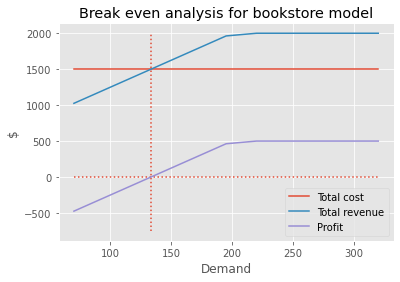

In [30]:
# Initialize plot
plt.style.use('ggplot')
fig, ax = plt.subplots()

# Create series variables
demand = np.array(m6_dt2_df['demand'])
cost = np.array(m6_dt2_df['order_cost'])
revenue = np.array(m6_dt2_df['total_revenue'])
profit = np.array(m6_dt2_df['profit'])

# Plot series
ax.plot(demand, cost, label='Total cost')
ax.plot(demand, revenue, label='Total revenue')
ax.plot(demand, profit, label='Profit')

# Style plot elements
ax.set(title='Break even analysis for bookstore model', xlabel='Demand', ylabel='$')
plt.hlines(0, 70, 320, linestyles='dotted')
plt.vlines(break_even_demand, -750, 2000, linestyles='dotted')
ax.legend(loc='lower right')

# Show the plot
plt.show()

## Wrap up and next steps
We have added a `goal_seek` function to our small but growing list of functions for doing Excelish things in Python. Yes, we can certainly improve our `goal_seek` implementation with better root finding algorithms, but this is good enough for now.

Along the way, hopefully you learned some new Python things, I know I did.

In the next installment of this series, we'll take on Monte-Carlo simulation.